In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py
import os
import time

from datasets import ASCADv1
from leakage_detectors.non_learning import get_trace_means, get_sum_of_differences, get_signal_to_noise_ratio

/home/min/a/jgammell/miniconda3/envs/sca-defense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


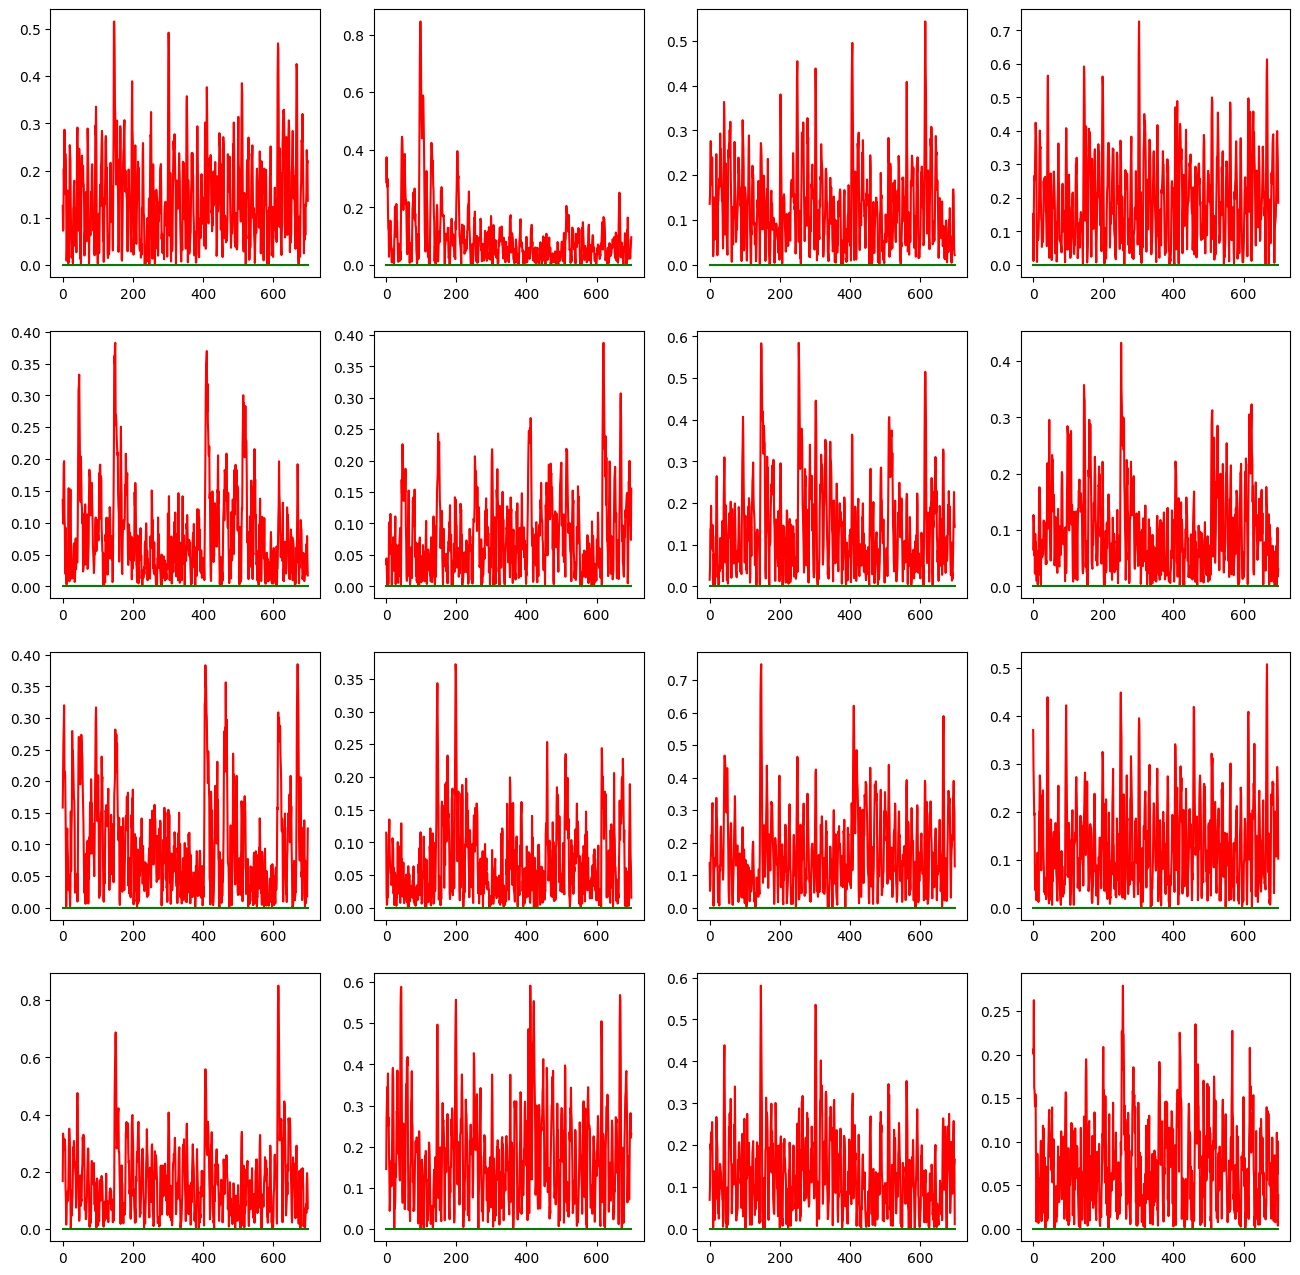

In [2]:
%matplotlib inline
d1 = ASCADv1(store_in_ram=True, remove_1o_leakage=False)
d1_trace_means = get_trace_means(d1)
d1_full_mean = np.mean(list(d1_trace_means.values()), axis=0)
d2 = ASCADv1(store_in_ram=True, remove_1o_leakage=True)
d2_trace_means = get_trace_means(d2)
d2_full_mean = np.mean(list(d2_trace_means.values()), axis=0)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for key, ax in zip(list(d1_trace_means.keys())[:16], axes.flatten()):
    #ax.plot(np.abs(d1_trace_means[key]-d2_trace_means[key]).squeeze(), color='blue')
    ax.plot(np.abs(d1_trace_means[key]-d1_full_mean).squeeze(), color='red')
    ax.plot(np.abs(d2_trace_means[key]-d2_full_mean).squeeze(), color='green')

In [3]:
dataset = ASCADv1(store_in_ram=True, use_full_traces=False, remove_1o_leakage=True)
print(dataset)

class RandomNoiseDataset:
    def __init__(self):
        self.traces = np.random.randn(50000, 1, 700)
        self.labels = np.random.randint(256, size=(50000,)).astype(np.uint8)
        self.data_shape = (1, 700)
    
    def __getitem__(self, idx):
        return self.traces[idx], self.labels[idx]
    
    def get_trace(self, idx, ret_targets=False):
        return self.traces[idx], self.labels[idx]
        
    def __len__(self):
        return len(self.traces)

random_noise_dataset = RandomNoiseDataset()

ASCADv1(
	resource_path=../resources/ascad_v1/ASCAD_data/ASCAD_databases/ASCAD.h5,
	store_in_ram=True,
	train=True,
	desync=0,
	data_transform=None,
	target_transform=None
)


In [4]:
resource_path = os.path.join('..', 'resources', 'ascad_v1', 'ASCAD_data', 'ASCAD_databases', 'ATMega8515_raw_traces.h5')
with h5py.File(resource_path) as database_file:
    print(database_file.keys())
    print(database_file['traces'].shape)
    print(database_file['metadata'].shape)
    print(database_file['metadata'][0].dtype)

<KeysViewHDF5 ['metadata', 'traces']>
(60000, 100000)
(60000,)
[('plaintext', 'u1', (16,)), ('ciphertext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (16,))]


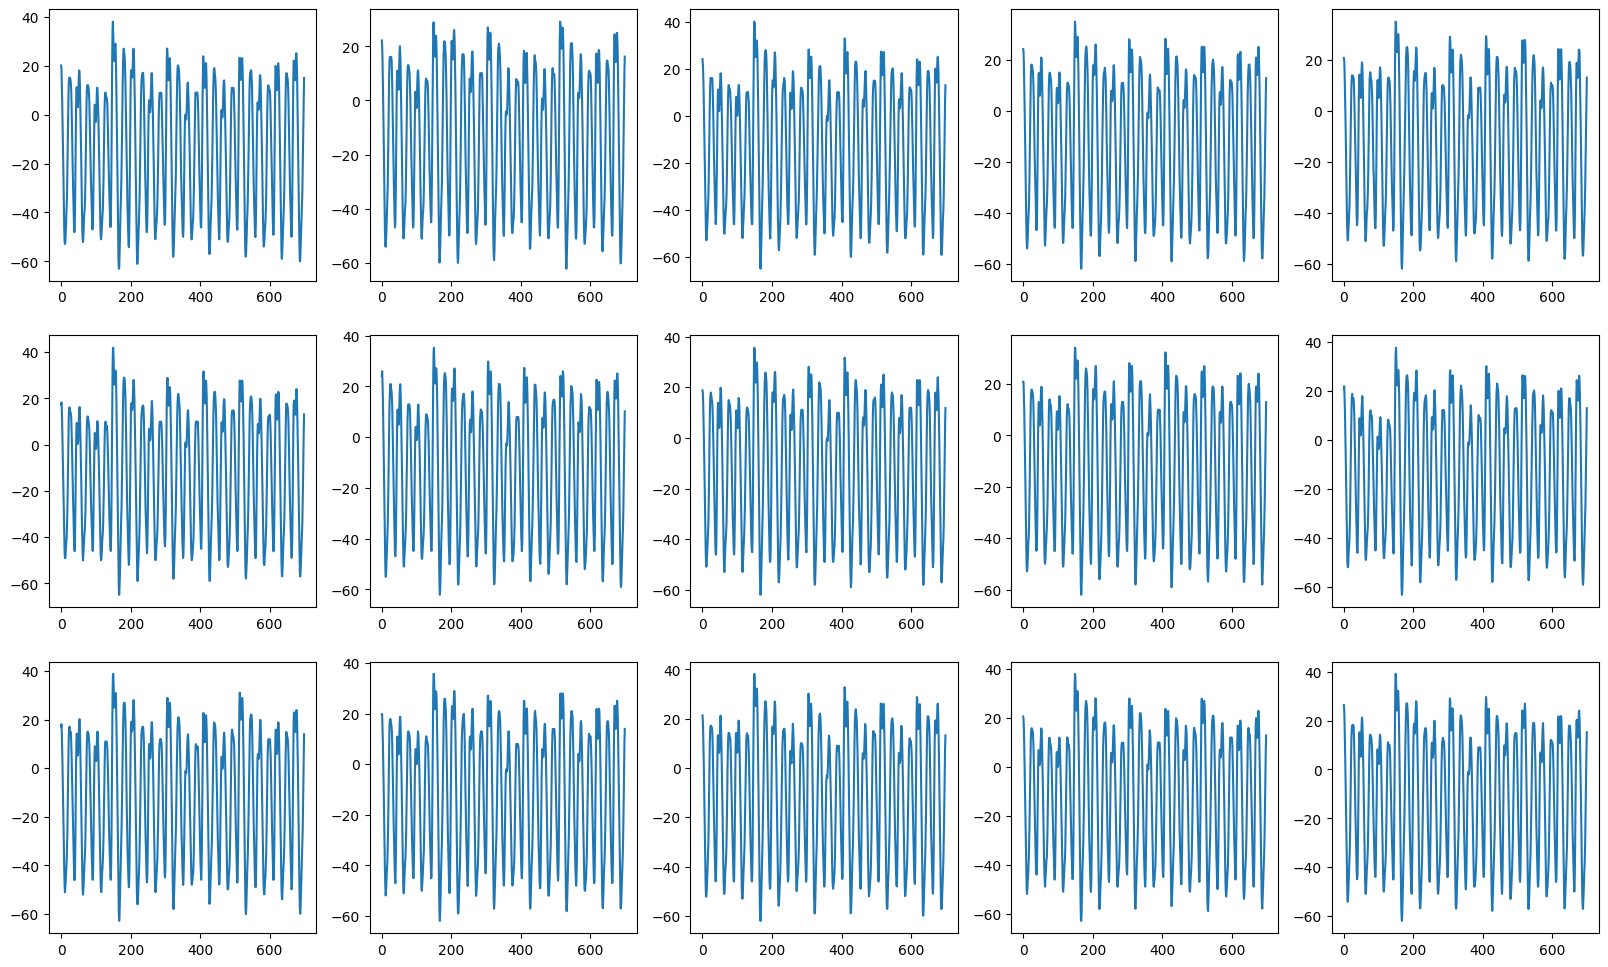

In [5]:
%matplotlib inline
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for idx, ax in enumerate(axes.flatten()):
    trace, _ = dataset[idx]
    trace = trace.squeeze()
    ax.plot(trace)

In [6]:
mean, var = np.zeros_like(trace), np.zeros_like(trace)
for idx, (trace, _) in enumerate(tqdm(dataset)):
    mean = (1/(idx+1))*trace.squeeze() + (idx/(idx+1))*mean
for idx, (trace, _) in enumerate(tqdm(dataset)):
    var = (1/(idx+1))*(trace.squeeze() - mean)**2 + (idx/(idx+1))*var
stdev = np.sqrt(var)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 90086.09it/s]


Text(0, 0.5, 'Std. deviation')

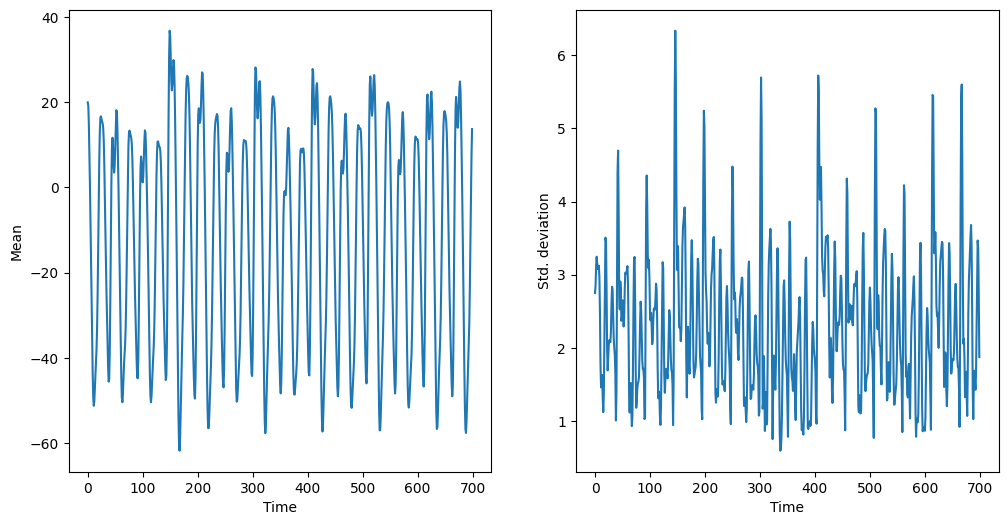

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(mean)
axes[1].plot(stdev)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mean')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Std. deviation')

In [8]:
trace_means = get_trace_means(dataset)
snr_mask = get_signal_to_noise_ratio(dataset, trace_means=trace_means)
random_means = get_trace_means(random_noise_dataset)
rand_snr_mask = get_signal_to_noise_ratio(random_noise_dataset, trace_means=random_means)

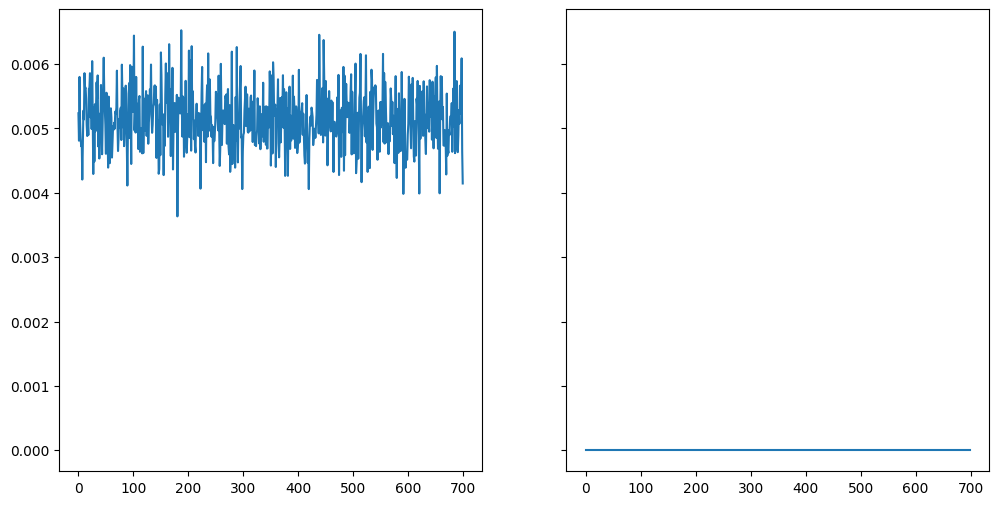

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].plot(rand_snr_mask.squeeze())
axes[1].plot(snr_mask.squeeze())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.02s/it]

Error in callback <function _draw_all_if_interactive at 0x7fd30a59e790> (for post_execute):



KeyboardInterrupt



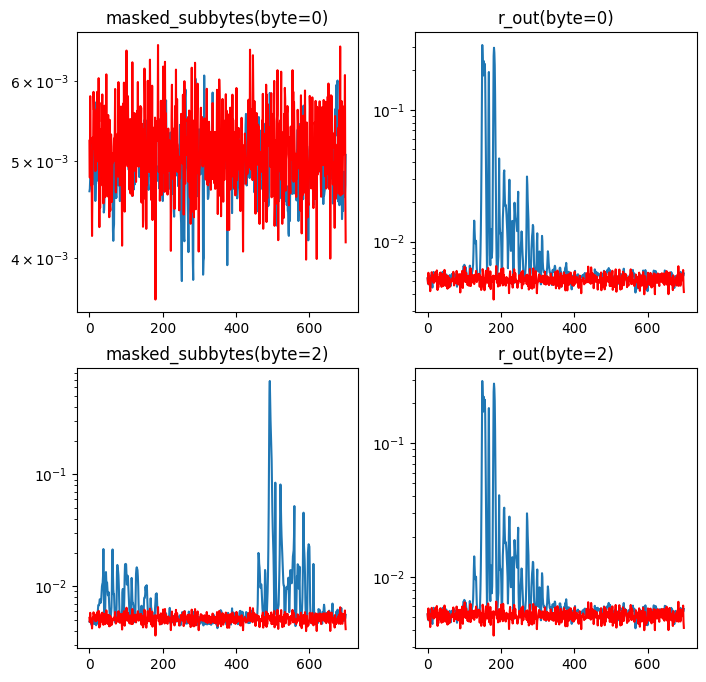

In [10]:
%matplotlib inline
target_variables = ['masked_subbytes', 'r_out']
target_bytes = [0, 2]
fig, axes = plt.subplots(len(target_bytes), len(target_variables), figsize=(4*len(target_variables), 4*len(target_bytes)))
progress_bar = tqdm(total=len(target_bytes)*len(target_variables))

for tb_idx, target_byte in enumerate(target_bytes):
    axes_r = axes[tb_idx, :]
    for tv_idx, target_variable in enumerate(target_variables):
        dataset.select_target(variables=target_variable, bytes=target_byte)
        ax = axes_r[tv_idx]
        snr_mask = get_signal_to_noise_ratio(dataset).squeeze()
        ax.plot(snr_mask)
        ax.plot(rand_snr_mask.squeeze(), color='red')
        ax.set_title(f'{target_variable}(byte={target_byte})')
        ax.set_yscale('log')
        progress_bar.update(1)

8it [00:17,  2.11s/it]                                                                                                                                                     

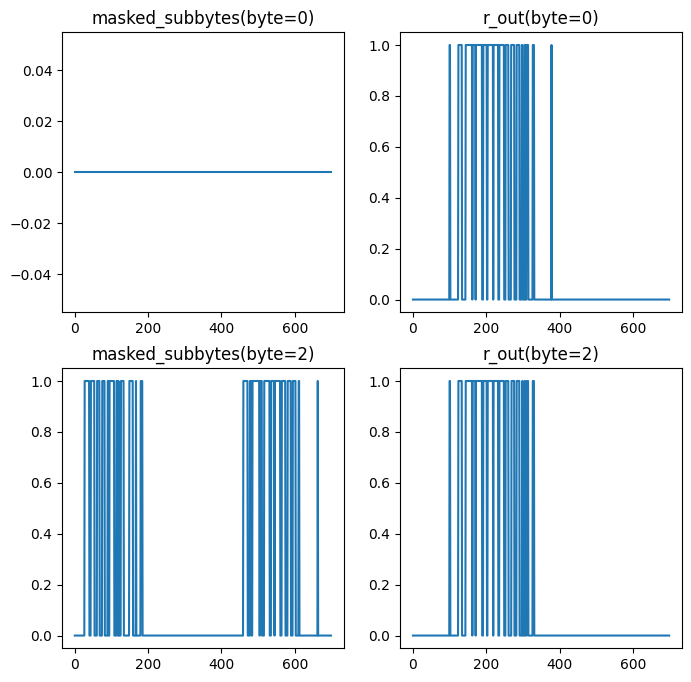

In [11]:
%matplotlib inline
from scipy.stats import norm
loc, scale = norm.fit(rand_snr_mask.squeeze())

fig, axes = plt.subplots(len(target_bytes), len(target_variables), figsize=(4*len(target_variables), 4*len(target_bytes)))
for tb_idx, target_byte in enumerate(target_bytes):
    axes_r = axes[tb_idx, :]
    for tv_idx, target_variable in enumerate(target_variables):
        dataset.select_target(variables=target_variable, bytes=target_byte)
        ax = axes_r[tv_idx]
        snr_mask = get_signal_to_noise_ratio(dataset).squeeze()
        ax.plot(norm.sf(snr_mask, loc=loc, scale=scale)<1e-3)
        ax.set_title(f'{target_variable}(byte={target_byte})')
        progress_bar.update(1)